In [2]:
import os
import numpy as np
from torchvision.datasets import CelebA
import matplotlib.pyplot as plt
import cv2
from PIL import Image


### 查看样本数据

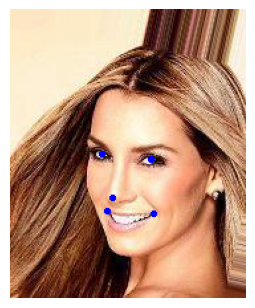

In [3]:
root_dir = '../datasets'
celeba = CelebA(root=root_dir, split='train',
                target_type=['attr', 'identity', 'bbox', 'landmarks'],
                download=False)
attr_names = celeba.attr_names
attr_names.pop()
attr_names = np.array(attr_names)    
fig = plt.figure(figsize=(14, 7))

n = 1 # 显示的图片数量
for idx in range(n):
    img, (attr, identity, bbox, landmarks) = celeba[idx]  # 读取图片和相关标签值
    ax = fig.add_subplot(1, 4, idx + 1)
    # 不显示刻度标签和边框
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(b=False)

    # 将CelebA数据集读取到的PIL图片格式转换成OprnCV所需格式
    # 图片的读取改为使用原图像
    file_path = os.path.join(celeba.root, celeba.base_folder, 'img_celeba', celeba.filename[idx])

    img_cv2 = cv2.imread(file_path)
    img_cv2 = cv2.cvtColor(src=np.asanyarray(img), code=cv2.COLOR_RGB2BGR)

    # 绘制特征点
    landmarks = landmarks.numpy()
    for idx, point in enumerate(landmarks):
        if idx % 2 == 0:
            cv2.circle(img=img_cv2, center=(point, landmarks[idx + 1]),
                        radius=1, color=(255, 0, 0), thickness=2)
            
    # 将OpenCV图片再次转成成Pillow图片格式
    img_pil = Image.fromarray( cv2.cvtColor(src=img_cv2,
                                            code=cv2.COLOR_BGR2RGB,))
    ax.imshow(img_pil)
plt.show()


### 查看标注框

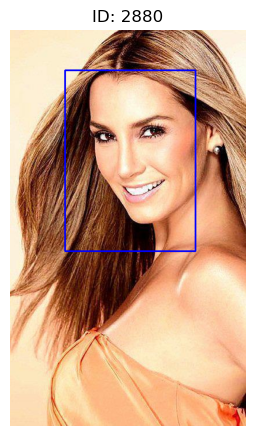

In [4]:

# 显示标注框
fig = plt.figure(figsize=(14, 7))
for idx in range(n):
    img, (attr, identity, bbox, landmarks) = celeba[idx]
    ax = fig.add_subplot(1, 4, idx + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(b=False)
    
    # 图片的读取改为使用原图像
    file_path = os.path.join(celeba.root, celeba.base_folder, 'img_celeba', celeba.filename[idx])

    img_cv2 = cv2.imread(file_path)
    bbox = bbox.numpy()
    cv2.rectangle(img=img_cv2, pt1=(bbox[0], bbox[1]),
                  pt2=(bbox[0] + bbox[2], bbox[1] + bbox[3]),
                  color=(255, 0, 0), thickness=2)
    cele_id = identity.numpy()
    ax.set_title(f'ID: {cele_id}')
    img_pil = Image.fromarray(cv2.cvtColor(src=img_cv2,
                                           code=cv2.COLOR_BGR2RGB,))
    ax.imshow(img_pil)
plt.show()

### 测试随机生成裁剪框的代码

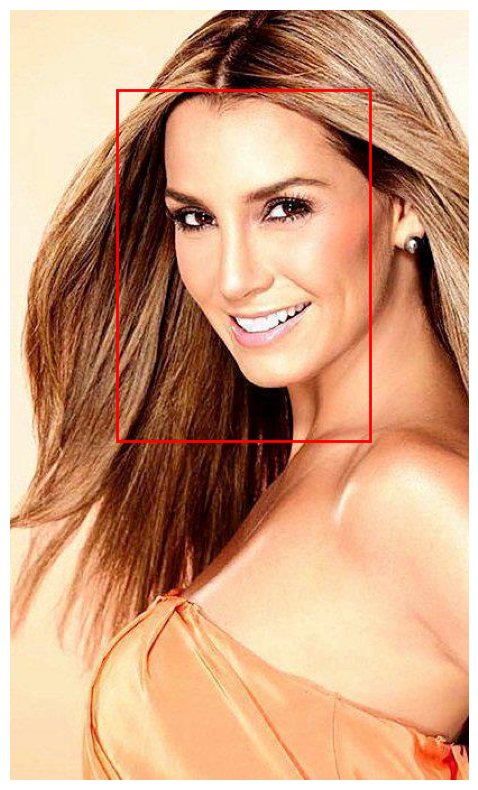

In [5]:
import os
import cv2
import numpy as np
from PIL import Image, ImageDraw

root_dir = '../datasets'
celeba = CelebA(root=root_dir, split='train',
                target_type=['attr', 'identity', 'bbox', 'landmarks'],
                download=False)
file_path = os.path.join(celeba.root, celeba.base_folder, 'img_celeba', celeba.filename[idx])

# 样本数据
sample_data = [
    {'image_id': '000001.jpg', 'x': 95, 'y': 71, 'width': 226, 'height': 313}
]

# 生成 generate_crop_boxes() 函数中使用的 float_num 列表
float_num = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def generate_crop_boxes(cx, cy, max_side, img_w, img_h):
    """
    根据给定的人脸中心点坐标和尺寸,生成5个候选的裁剪框。
    
    参数:
    cx (float): 人脸中心点的 x 坐标
    cy (float): 人脸中心点的 y 坐标
    max_side (int): 人脸框的最大边长
    img_w (int): 图像宽度
    img_h (int): 图像高度
    
    返回:
    crop_boxes (list): 一个包含5个裁剪框坐标的列表,每个裁剪框的格式为 [x1, y1, x2, y2]
    """

    crop_boxes = []
    for _ in range(5):
        # 随机偏移中心点坐标以及边长
        seed = float_num[np.random.randint(0, len(float_num))]

        # 最大边长随机偏移
        _max_side = max_side + np.random.randint(int(-max_side * seed), int(max_side * seed))

        # 中心点x坐标随机偏移
        _cx = cx + np.random.randint(int(-cx * seed), int(cx * seed))

        # 中心点y坐标随机偏移
        _cy = cy + np.random.randint(int(-cy * seed), int(cy * seed))

        # 得到偏移后的坐标值（方框）
        _x1 = _cx - _max_side / 2
        _y1 = _cy - _max_side / 2
        _x2 = _x1 + _max_side
        _y2 = _y1 + _max_side

        # 偏移过大，偏出图像了，此时，不能用，应该再次尝试偏移
        # if _x1 < 0 or _y1 < 0 or _x2 > img_w or _y2 > img_h:
        #     continue
        
        # 添加裁剪框坐标到列表中
        crop_boxes.append(np.array([_x1, _y1, _x2, _y2]))
    
    return crop_boxes

def test_crop_boxes():
    for sample in sample_data:
        # 读取图像
        img_path = os.path.join('../datasets', 'celeba', 'img_celeba', sample['image_id'])
        img = cv2.imread(img_path)
        img_h, img_w, _ = img.shape

        # 根据样本数据生成原始框
        x1 = sample['x']
        y1 = sample['y']
        x2 = x1 + sample['width']
        y2 = y1 + sample['height']

        # 生成 5 个随机裁剪框
        crop_boxes = generate_crop_boxes(x1 + sample['width'] / 2, y1 + sample['height'] / 2, max(sample['width'], sample['height']), img_w, img_h)

        # 在图像上绘制原始框和随机裁剪框
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # 绘制原始框
        rect = plt.Rectangle((x1, y1), sample['width'], sample['height'], fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(rect)

        # 绘制随机裁剪框
        for box in crop_boxes:
            x1, y1, x2, y2 = box.astype(int)
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='b', linewidth=2)
            ax.add_patch(rect)

        ax.axis('off')
        plt.show()

if __name__ == '__main__':
    test_crop_boxes()
